<a href="https://colab.research.google.com/github/nwon24/basel/blob/main/Basel_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Neural Networks for Weather Pattern Prediction

Weather forecasting is an inherently difficult time-series prediction problem due to the inherently chaotic nature of weather systems.
In [1] it is suggested that a Quantum Neural Network (QNN) may outperform a classical Recurrent Neural Network (RNN) in short to medium term weather prediction.
Here we aim to replicate the results of [1] on a different dataset for short-term time horizons with the same quantum ansatz.

The datasets and PyTorch models for this project can be found at https://github.com/nwon24/basel.

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset,DataLoader,TensorDataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from datetime import date

!pip install pennylane qiskit pennylane-qiskit pylatexenc
import pennylane as qml
from qiskit import QuantumCircuit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [2]:
!wget https://raw.githubusercontent.com/nwon24/basel/refs/heads/main/data/Basel_2020-23.csv
!wget https://raw.githubusercontent.com/nwon24/basel/refs/heads/main/data/Basel_2024-25.csv
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_LSTM_2026-02-02_49e_8h_1l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_LSTM_2026-02-03_49e_16h_1l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_LSTM_2026-02-03_49e_24h_1l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_LSTM_2026-02-04_49e_1h_1l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-02_49e_8h_1l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-02_49e_8h_2l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-02_49e_8h_3l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-02_49e_8h_4l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-03_49e_16h_1l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-03_49e_16h_2l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-03_49e_16h_3l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-03_49e_16h_4l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-03_49e_16h_5l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-03_49e_8h_5l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-05_49e_1h_1l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-05_49e_1h_2l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-06_49e_1h_3l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-07_49e_1h_4l.pth
!wget https://github.com/nwon24/basel/raw/refs/heads/main/models/Basel_QNN_2026-02-08_49e_1h_5l.pth

--2026-02-15 20:45:21--  https://raw.githubusercontent.com/nwon24/basel/refs/heads/main/data/Basel_2020-23.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839392 (820K) [text/plain]
Saving to: ‘Basel_2020-23.csv’

Basel_2020-23.csv   100%[===================>] 819.72K  --.-KB/s    in 0.01s   

2026-02-15 20:45:21 (81.8 MB/s) - ‘Basel_2020-23.csv’ saved [839392/839392]

--2026-02-15 20:45:21--  https://raw.githubusercontent.com/nwon24/basel/refs/heads/main/data/Basel_2024-25.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4

The data used consists of hourly temeperature readings in Basel, Switzerland, at an elevation of 2m.
Historical weather data for Basel can be found at https://www.meteoblue.com/en/weather/archive/export.

The training/test data set consists of four years of data, from 2020 to 2023,
with 2020-2022 for training and 2023 for testing.
The models are then validated on weather data from 2024 to 2025.
All data is normalised to be in the range $(0,1)$.


In [3]:
file="Basel_2020-23.csv"
file2="Basel_2024-25.csv"

df=pd.read_csv(file,delimiter=",",skiprows=10,usecols=[1],encoding="utf-8",header=None)
df2=pd.read_csv(file2,delimiter=",",skiprows=10,usecols=[1],encoding="utf-8",header=None)
nparr=df.to_numpy(dtype=np.float64)
nparr2=df2.to_numpy(dtype=np.float64)

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-4014803629.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Temperature ($^\circ$C)")
/tmp/ipython-input-4014803629.py:9: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Temperature ($^\circ$C)")


Text(0.5, 1.0, 'Basel weather 2024-2025')

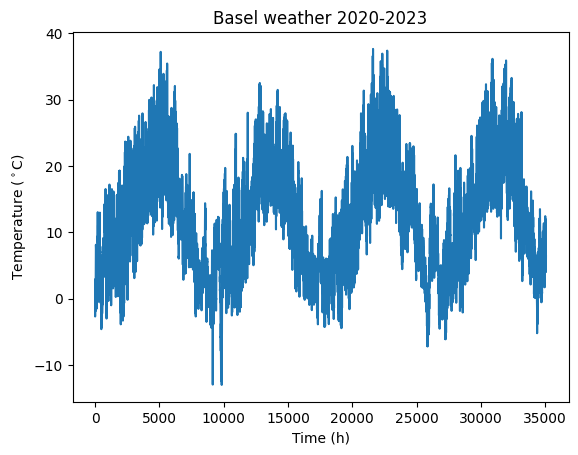

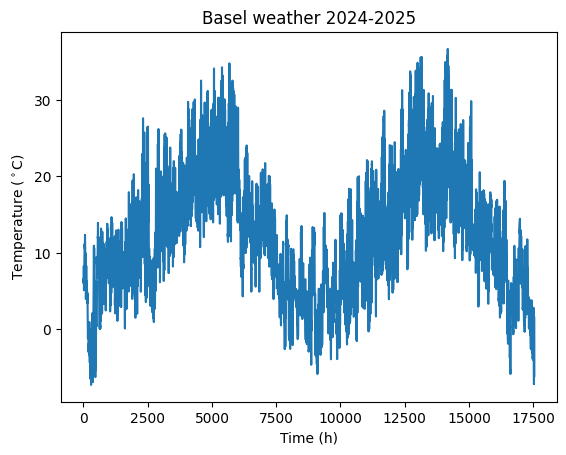

In [6]:
plt.plot(np.arange(np.size(nparr)),nparr,)
plt.xlabel("Time (h)")
plt.ylabel("Temperature ($^\circ$C)")
plt.title("Basel weather 2020-2023")

plt.figure()
plt.plot(np.arange(np.size(nparr2)),nparr2,)
plt.xlabel("Time (h)")
plt.ylabel("Temperature ($^\circ$C)")
plt.title("Basel weather 2024-2025")

A time lag of $8$ hours was chosen.
This seemed to be a good balance between being able to test the temporal abilities of the models while maintaining relatively low training times, especially for the simulated quantum models.

In [ ]:
predwin=8
nqubits=predwin

In [ ]:
testhours=365*24
totalhours=nparr.size
train_split=nparr[:-testhours]
test_split=nparr[-testhours:]
valid_split=nparr2

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
train_data=(torch.from_numpy(scaler.fit_transform(train_split)))
test_data=(torch.from_numpy(scaler.transform(test_split)))
valid_data=(torch.from_numpy(scaler.transform(valid_split)))

In [ ]:
def preparexy(data,predwin,horizon):
    n=(len(data)-predwin)//horizon
    x=torch.zeros((n,predwin,1))
    y=torch.zeros((n,horizon,1))
    for i in range(n):
        x[i]=data[i:i+predwin]
        y[i]=data[i+predwin:i+predwin+horizon]
    return x,y

The classical model is an LSTM with a single layer.
Initial experiments were performed with multiple layers and nonzero dropout, but this did not significantly increase the model's accuracy, at the cost of longer training times.

In [ ]:
class lstm(nn.Module):
    def __init__(self,inputsize,hiddensize,nlayers,outputsize,batch_first=True,dropout=0.0):
        super().__init__()
        self.inputsize=inputsize
        self.hiddensize=hiddensize
        self.nlayers=nlayers
        self.batch_first=batch_first
        self.outputsize=outputsize
        self.dropout=dropout
        self.lstm=nn.LSTM(self.inputsize,self.hiddensize,self.nlayers,batch_first=self.batch_first,dropout=dropout)
        self.linear=nn.Linear(self.hiddensize,outputsize)

    def forward(self,x):
        out,_=self.lstm(x)
        return self.linear(out[:,-1,:])

In [ ]:
inputsize=1
nlayers=1
hiddensize=128
dropout=0

In [ ]:
def validate(model,valid_data,xvalid,yvalid,shape,predwin,horizon,start=None,end=None):
    model.eval()
    with torch.no_grad():
        nhours=len(valid_data)
        n=len(xvalid)
        t=np.arange(nhours)
        forecasts=[]
        for i in range(n):
            y=model(xvalid[i].reshape(shape))
            forecasts.append(y.detach().numpy())
        forecasts=np.array(forecasts).flatten()
        transformed_forecasts=scaler.inverse_transform(forecasts.reshape(-1,1))
        transformed_y=scaler.inverse_transform(yvalid.detach().numpy().reshape(-1,1))

        return r2_score(transformed_y,transformed_forecasts), mean_squared_error(transformed_y,transformed_forecasts)

In [ ]:
def numparams(model):
    return sum(p.numel() for p in model.parameters())

The quantum ansatz chosen is the same as the one outlined in [1].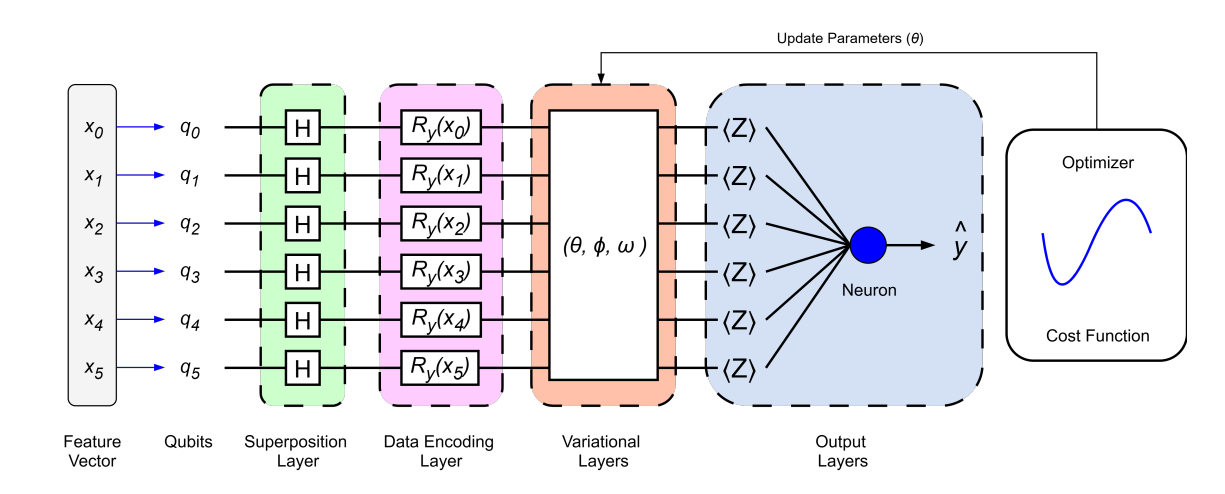

First a series of Hadamard gates are used to place the qubits in superposition, before the features are encoded via rotations around the $y$-axis.
The variational layers are the core of the QNN.
Each consists of a circular ladder of CNOT gates to create entanglement, before rotations parametrised by the model's weights are performed around each of the three axes.
The number of times this sequence of entanglement and parametrised rotation is performed is called the depth or the number of layers of the QNN.

The output of the QNN is obtained by eestimating the expectation value of the $Z$ operator on each of the qubits.
These expectations values are then fed into a single linear layer, the output of which is the time hozrizon of the model.
Here time horizons of 1 hour, 8 hours, and 16 hours were considered.

All models were trained for $50$ epochs with a learning rate of $10^{-3}$ using the `Adam` optimiser.

In [ ]:
qpredwin=predwin
nqubits=qpredwin
qdev="lightning.qubit"
dev=qml.device(qdev)

@qml.qnode(dev)
def qnode(inputs,weights):
    qubits=weights.shape[1]
    layers=weights.shape[0]
    for i in range(qubits):
        qml.Hadamard(wires=i)
        qml.RY(inputs[i],wires=i)

    for i in range(layers):
        for j in range(qubits-1):
            qml.CNOT(wires=[j,j+1])
        qml.CNOT(wires=[0,qubits-1])
        for j in range(qubits):
            qml.Rot(*weights[i][j],wires=j)
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [ ]:
class qmodel(nn.Module):
    def __init__(self,nqubits,qlayer,outputsize):
        super().__init__()
        self.qlayer=qlayer
        self.nqubits=nqubits
        self.outputsize=outputsize
        self.lin=nn.Linear(nqubits,outputsize)

    def forward(self,x):
        y=self.qlayer(x)
        return self.lin(y)

In [ ]:
def loadqnn(nlayers,nqubits,qoutputsize):
    weightshapes={"weights": (nlayers,nqubits,3)}
    qlayer=qml.qnn.TorchLayer(qnode,weightshapes)
    qnn=qmodel(nqubits,qlayer,qoutputsize)
    return qnn

In [ ]:
nummodels=6
numhorizons=3
results_r2=np.zeros((nummodels,numhorizons))
results_mse=np.zeros((nummodels,numhorizons))
nparams=np.zeros((nummodels,numhorizons),dtype=np.int64)

# 1 hour horizon

In [ ]:
horizon=1
outputsize=horizon
model=lstm(inputsize,hiddensize,nlayers,outputsize,dropout=dropout)
xvalid,yvalid=preparexy(valid_data,predwin,horizon)

In [ ]:
model.load_state_dict(torch.load("Basel_LSTM_2026-02-04_49e_1h_1l.pth",weights_only=True))
nparams[0][0]=numparams(model)

In [ ]:
result=validate(model,valid_data,xvalid,yvalid,(1,-1,1),predwin,horizon,start=None,end=None)
results_r2[0][0]=result[0]
results_mse[0][0]=result[1]

In [ ]:
qhorizon=horizon
qoutputsize=qhorizon

In [ ]:
# 5 layers
qnn=loadqnn(5,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-08_49e_1h_5l.pth",weights_only=True))
nparams[-1][0]=numparams(qnn)


In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-1][0]=result[0]
results_mse[-1][0]=result[1]

In [ ]:
# 4 layers
qnn=loadqnn(4,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-07_49e_1h_4l.pth",weights_only=True))
nparams[-2][0]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-2][0]=result[0]
results_mse[-2][0]=result[1]

In [ ]:
# 3 layers
qnn=loadqnn(3,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-06_49e_1h_3l.pth",weights_only=True))
nparams[-3][0]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-3][0]=result[0]
results_mse[-3][0]=result[1]

In [ ]:
# 2 layers
qnn=loadqnn(2,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-05_49e_1h_2l.pth",weights_only=True))
nparams[-4][0]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-4][0]=result[0]
results_mse[-4][0]=result[1]

In [ ]:
# 1 layer
qnn=loadqnn(1,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-05_49e_1h_1l.pth",weights_only=True))
nparams[-5][0]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-5][0]=result[0]
results_mse[-5][0]=result[1]

# 8 hour horizon

In [ ]:
horizon=8
outputsize=horizon
xvalid,yvalid=preparexy(valid_data,predwin,horizon)
model=lstm(inputsize,hiddensize,nlayers,outputsize,dropout=dropout)

In [ ]:
model.load_state_dict(torch.load("Basel_LSTM_2026-02-02_49e_8h_1l.pth",weights_only=True))
nparams[0][1]=numparams(model)

In [ ]:
result=validate(model,valid_data,xvalid,yvalid,(1,-1,1),predwin,horizon,start=None,end=None)
results_r2[0][1]=result[0]
results_mse[0][1]=result[1]

In [ ]:
# 5 layers
qhorizon=horizon
qoutputsize=qhorizon
qnn=loadqnn(5,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-03_49e_8h_5l.pth",weights_only=True))
nparams[-1][1]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-1][1]=result[0]
results_mse[-1][1]=result[1]

In [ ]:
# 4 layers
qnn=loadqnn(4,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-02_49e_8h_4l.pth",weights_only=True))
nparams[-2][1]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-2][1]=result[0]
results_mse[-2][1]=result[1]

In [ ]:
# 3 layers
qnn=loadqnn(3,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-02_49e_8h_3l.pth",weights_only=True))
nparams[-3][1]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-3][1]=result[0]
results_mse[-3][1]=result[1]

In [ ]:
# 2 layers
qnn=loadqnn(2,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-02_49e_8h_2l.pth",weights_only=True))
nparams[-4][1]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-4][1]=result[0]
results_mse[-4][1]=result[1]

In [ ]:
# 1 layer
qnn=loadqnn(1,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-02_49e_8h_1l.pth",weights_only=True))
nparams[-5][1]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-5][1]=result[0]
results_mse[-5][1]=result[1]

# 16 hour horizon

In [ ]:
horizon=16
outputsize=horizon
xvalid,yvalid=preparexy(valid_data,predwin,horizon)
model=lstm(inputsize,hiddensize,nlayers,outputsize,dropout=dropout)

In [ ]:
model.load_state_dict(torch.load("Basel_LSTM_2026-02-03_49e_16h_1l.pth",weights_only=True))
nparams[0][2]=numparams(model)

In [ ]:
result=validate(model,valid_data,xvalid,yvalid,(1,-1,1),predwin,horizon,start=None,end=None)
results_r2[0][2]=result[0]
results_mse[0][2]=result[1]

In [ ]:
# 5 layers
qhorizon=horizon
qoutputsize=qhorizon
qnn=loadqnn(5,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-03_49e_16h_5l.pth",weights_only=True))
nparams[-1][2]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-1][2]=result[0]
results_mse[-1][2]=result[1]

In [ ]:
# 4 layers
qnn=loadqnn(4,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-03_49e_16h_4l.pth",weights_only=True))
nparams[-2][2]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-2][2]=result[0]
results_mse[-2][2]=result[1]

In [ ]:
# 3 layers
qnn=loadqnn(3,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-03_49e_16h_3l.pth",weights_only=True))
nparams[-3][2]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-3][2]=result[0]
results_mse[-3][2]=result[1]

In [ ]:
# 2 layers
qnn=loadqnn(2,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-03_49e_16h_2l.pth",weights_only=True))
nparams[-4][2]=numparams(qnn)

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-4][2]=result[0]
results_mse[-4][2]=result[1]

In [ ]:
# 1 layer
qnn=loadqnn(1,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("Basel_QNN_2026-02-03_49e_16h_1l.pth",weights_only=True))
nparams[-5][2]=numparams(qnn)

# Results Summary

In [ ]:
result=validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)
results_r2[-5][2]=result[0]
results_mse[-5][2]=result[1]

In [ ]:
np.savetxt("results_r2.csv",results_r2,fmt="%.10f",delimiter=",",header="1h,8h,16h")

In [ ]:
np.savetxt("results_mse.csv",results_mse,fmt="%.10f",delimiter=",",header="1h,8h,16h")

In [ ]:
np.savetxt("nparams.csv",nparams,fmt="%.10f",delimiter=",",header="1h,8h,16h")

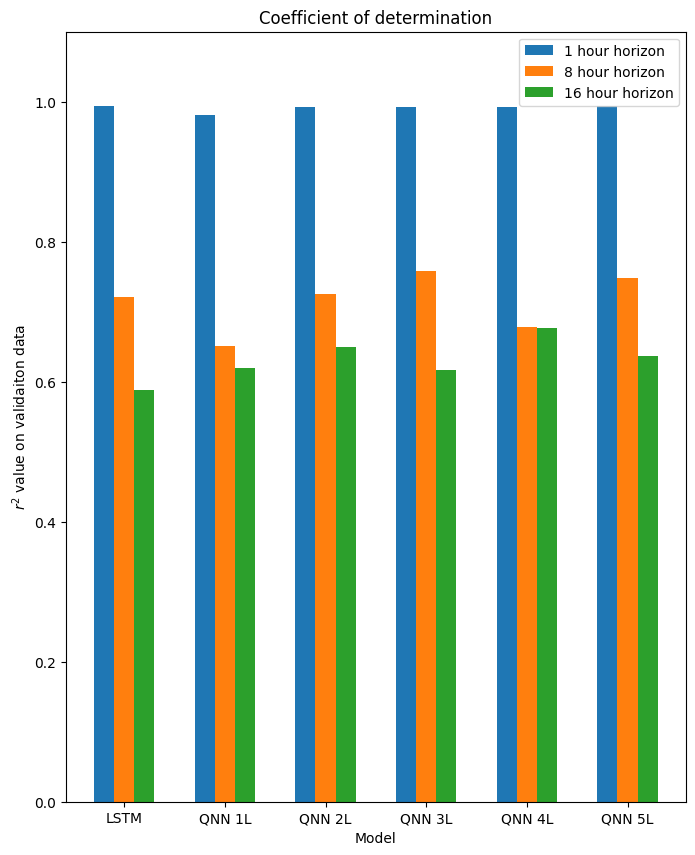

In [ ]:
models=["LSTM", "QNN 1L", "QNN 2L", "QNN 3L", "QNN 4L", "QNN 5L"]
x=np.arange(len(models))
width=0.2
plt.figure(0,(8,10))
plt.bar(x-width,results_r2[:,0],width=width,label="1 hour horizon")
plt.bar(x,results_r2[:,1],width=width,label="8 hour horizon")
plt.bar(x+width,results_r2[:,2],width=width,label="16 hour horizon")
plt.xticks(x,models)
plt.xlabel("Model")
plt.ylabel("$r^2$ value on validaiton data")
plt.ylim(0,1.1)
plt.title("Coefficient of determination")
plt.legend(loc="best")
plt.show()

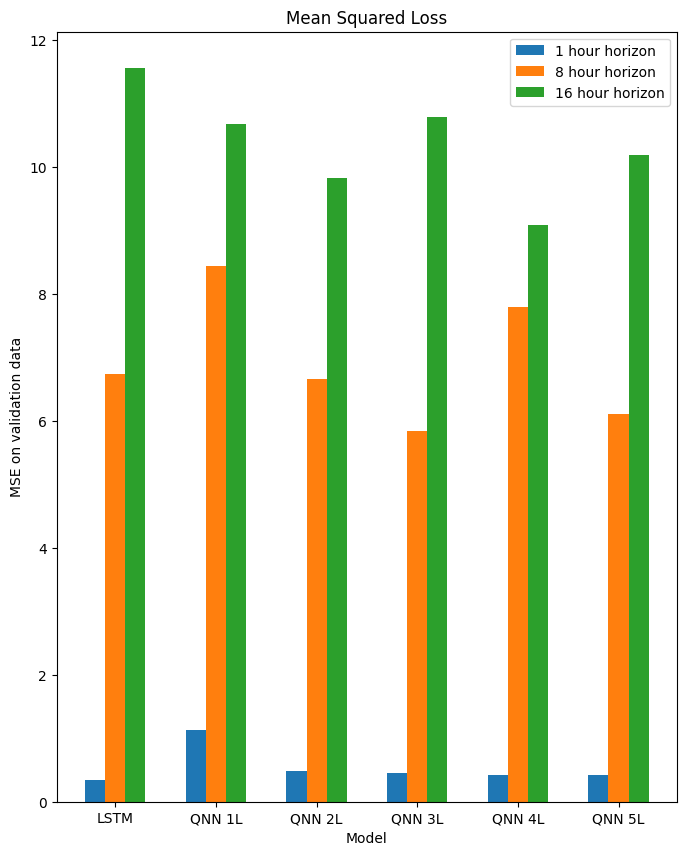

In [ ]:
plt.figure(1,(8,10))
plt.bar(x-width,results_mse[:,0],width=width,label="1 hour horizon")
plt.bar(x,results_mse[:,1],width=width,label="8 hour horizon")
plt.bar(x+width,results_mse[:,2],width=width,label="16 hour horizon")
plt.xticks(x,models)
plt.xlabel("Model")
plt.ylabel("MSE on validation data")
plt.title("Mean Squared Loss")
plt.legend(loc="best")
plt.show()

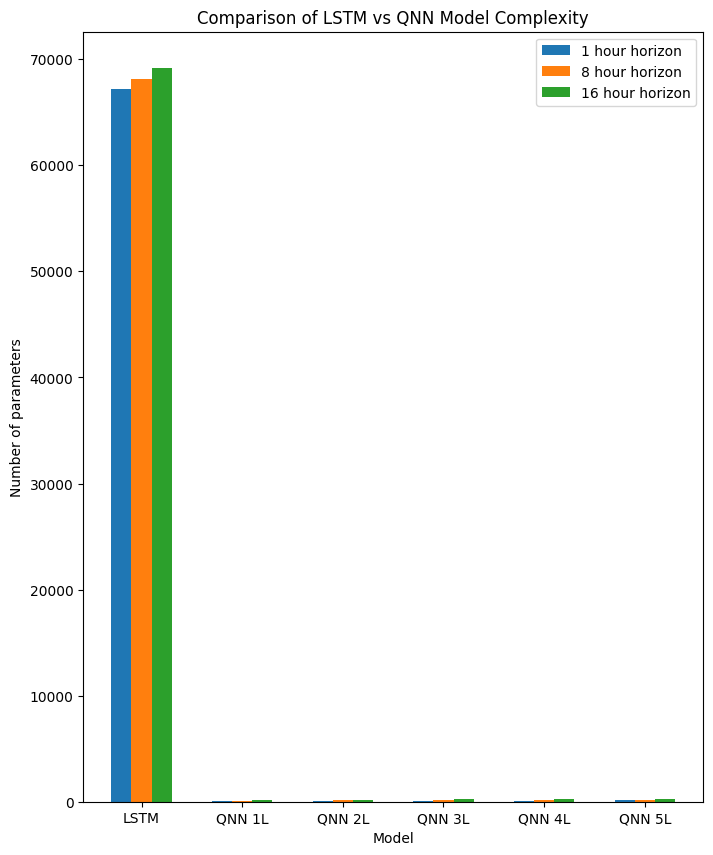

In [ ]:
plt.figure(2,(8,10))
plt.bar(x-width,nparams[:,0],width=width,label="1 hour horizon")
plt.bar(x,nparams[:,1],width=width,label="8 hour horizon")
plt.bar(x+width,nparams[:,2],width=width,label="16 hour horizon")
plt.xticks(x,models)
plt.xlabel("Model")
plt.ylabel("Number of parameters")
plt.title("Comparison of LSTM vs QNN Model Complexity")
plt.legend(loc="best")
plt.show()

# Quantum circuit visualisation

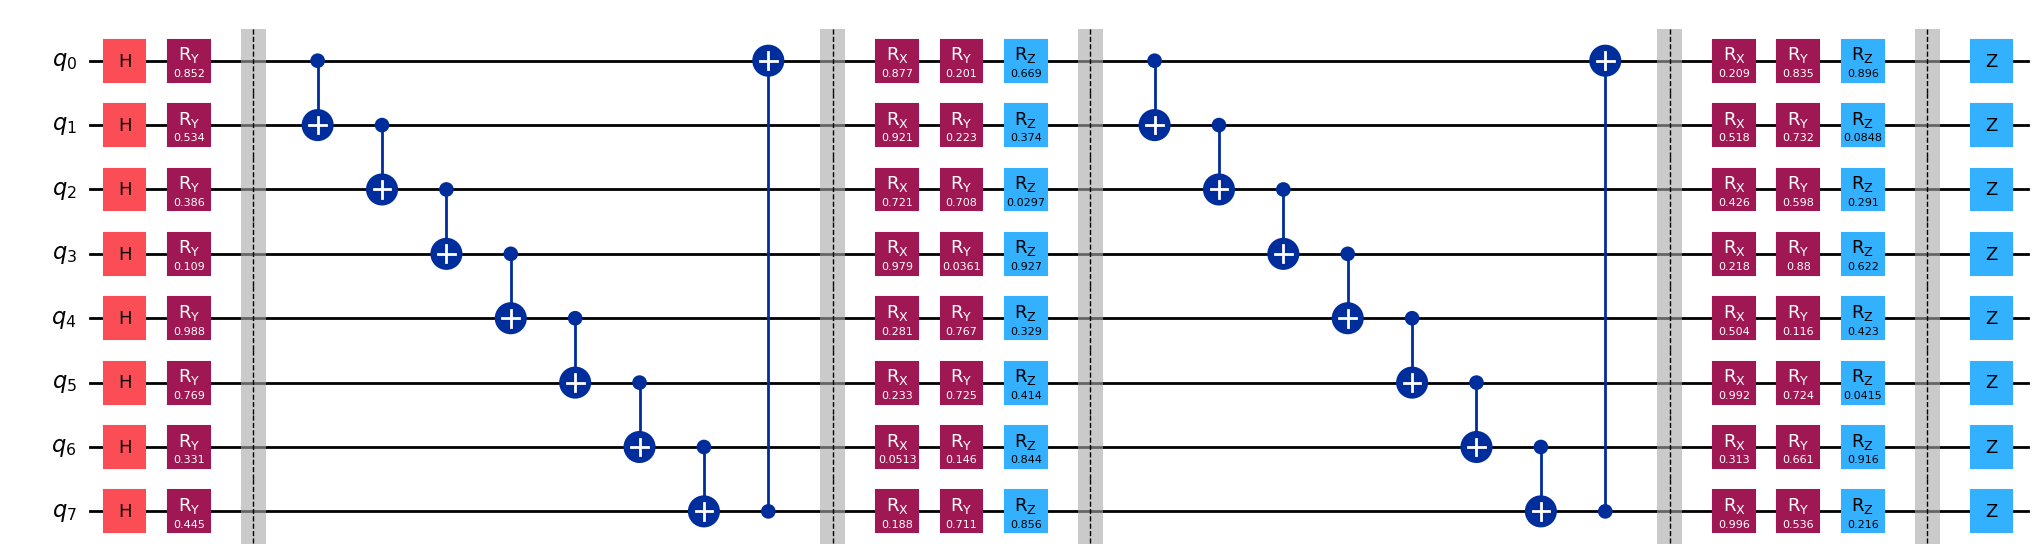

In [ ]:
dev=qml.device("qiskit.aer",wires=nqubits)
input=np.random.rand(nqubits)
nlayers=2
weights=np.random.rand(nlayers,nqubits,3)

qc=QuantumCircuit(nqubits)
for i in range(nqubits):
    qc.h(i)
    qc.ry(input[i],i)
qc.barrier()
for i in range(nlayers):
    for j in range(nqubits-1):
        qc.cx(j,j+1)
    qc.cx(nqubits-1,0)
    qc.barrier()
    for j in range(nqubits):
        qc.rx(weights[i][j][0],j)
        qc.ry(weights[i][j][1],j)
        qc.rz(weights[i][j][2],j)
    qc.barrier()

for i in range(nqubits):
    qc.z(i)

qc.draw("mpl",fold=-1)


# References

[1] da Silva, Maria Heloisa F., de Jesus, Gleydson F., Nascimento, Christiano M. S., da Silva, Valeria L., Cruz, Clebson S. *Exploring Quantum Machine Learning for Weather Forecasting*. September 3, 2025. https://arxiv.org/abs/2509.01422